In [212]:
import pandas as pd #libreria de analisis de datos y herramientas de manipulación
import matplotlib.pyplot as plt #libreria para generacion de graficos
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform

In [213]:
retail="OnlineRetail.csv"

#ubicacion de datos y notebook en mismo directorio
df_retail = pd.read_csv(retail, encoding="ISO-8859-1")



Estudio base de datos OnlineRetail.csv


---


#### Limpieza Datos (...)

In [214]:
df_retail.describe()

#Se pueden observar valores negativos en UnitPrice y Quantity, Nulls en CustomerID. 
#Posibles valores excesivamente altos en Quantity   

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [215]:
df_retail["Description"] = df_retail.Description.str.lower() #descripción en minuscula
df_retail.isnull().sum().sort_values(ascending=False) #búsqueda de nulos

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [216]:
#Verificar qué contienen los NaN que borraremos desde Description
por_borrar = df_retail[df_retail['Description'].isna()]
por_borrar.describe()

,Quantity,UnitPrice,CustomerID
count,1454.000000,1454.0,0.0
mean,-9.359697,0.0,NaN
std,243.238758,0.0,NaN
min,-3667.000000,0.0,NaN
25%,-24.000000,0.0,NaN
50%,-3.000000,0.0,NaN
75%,4.000000,0.0,NaN
max,5568.000000,0.0,NaN


In [217]:
#Verificar qué significa el precio negativo antes de borrar
por_borrar2 = df_retail[df_retail["UnitPrice"]<0]
por_borrar2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


* Borraremos las filas con NaN en Description, ya que no conocer qué se vende, ni su precio, ni el costumerID para inferir la compra, no aportan datos relevantes al estudio. Deben ser registros de compras no realizadas.
* Consideramos a los customerID = NaN como un cliente no socio, pero para el análisis nos sirve considerar esas compras y no las borraremos.


In [218]:
df_retail = df_retail.dropna(subset=['Description']) #eliminación nulls en columna determinada
df_retail = df_retail[df_retail["UnitPrice"]>=0] #eliminación precios negativos
df_retail.describe()

,Quantity,UnitPrice,CustomerID
count,540453.000000,540453.000000,406829.000000
mean,9.603161,4.664472,15287.690570
std,218.008001,94.522031,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


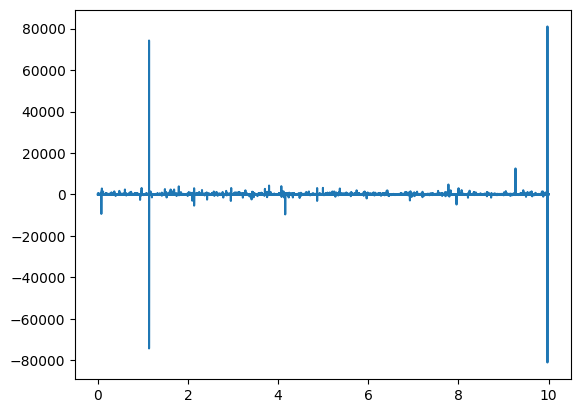

In [219]:
#Eliminar Outliers de Quantity
por_borrar3=df_retail["Quantity"]
plt.plot(np.linspace(0,10,num=len(por_borrar3)),por_borrar3)
plt.show()

In [220]:
#Eliminar Outliers de Quantity
df_retail = df_retail[(df_retail["Quantity"]>-20000) & (df_retail["Quantity"]<20000)]

In [221]:
#Verificamos el contenido de datos con Description = "?"
#Estos serán borrados ya que tampoco tienen precio y las cantidades no tienen sentido
por_borrar4 = df_retail[df_retail["Description"]=="?"]
por_borrar4.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
7313,537032,21275,?,-30,12/3/2010 16:50,0.0,NaN,United Kingdom
21518,538090,20956,?,-723,12/9/2010 14:48,0.0,NaN,United Kingdom
38261,539494,21479,?,752,12/20/2010 10:36,0.0,NaN,United Kingdom
43662,540100,22837,?,-106,1/4/2011 16:53,0.0,NaN,United Kingdom
50806,540558,21258,?,-29,1/10/2011 10:04,0.0,NaN,United Kingdom


In [222]:
df_retail = df_retail[df_retail["Description"]!="?"]

In [223]:
#Investigando al respecto a los datos se concluye que cantidades negativas representan facturas canceladas
#Se identifican con la letra "C" al inicio del ID del InvoiceNo

canceladas = df_retail[(df_retail["Quantity"]<0) & (df_retail["UnitPrice"]>0)]
for i in canceladas["InvoiceNo"].tolist():
#verificar si no hay alguna venta no identificada como cancelada en el grupo con cantidad negativa
  if i[0] != "C": 
    print(i)
por_borrar5 = canceladas.index.to_list()
df_retail = df_retail.drop(index=por_borrar5) #eliminación por índice

In [224]:
# ** Se pueden borrar además el resto de datos con Quantity < 0 (?)** 
# El resto no identificado con "C", equivale a errores de transacción, checkeos, desperdicios, ventas dañadas
otras_negativas = df_retail[df_retail["Quantity"]<0]
otras_negativas[80:85]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
174654,551837,79164,damages/credits from asos.,-1512,5/4/2011 13:23,0.0,NaN,United Kingdom
180618,552331,22667,damaged,-30,5/9/2011 10:24,0.0,NaN,United Kingdom
181042,552443,22796,not rcvd in 10/11/2010 delivery,-360,5/9/2011 13:05,0.0,NaN,United Kingdom
185113,552733,23059,thrown away-rusty,-2376,5/11/2011 10:48,0.0,NaN,United Kingdom
189299,553147,84879,damaged,-160,5/13/2011 13:58,0.0,NaN,United Kingdom


In [225]:
#Filtro total de Cantidades >= 0
df_retail = df_retail[df_retail["Quantity"]>=0]

In [226]:
#Corrección formato de fecha
df_retail['InvoiceDate'] = pd.to_datetime(df_retail.InvoiceDate, format="%m/%d/%Y %H:%M" )

In [227]:
df_retail.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,530683.000000,530683,530683.000000,397922.000000
mean,10.298257,2011-07-04 19:01:35.814374400,3.903356,15294.319686
min,1.000000,2010-12-01 08:26:00,0.000000,12347.000000
25%,1.000000,2011-03-28 11:59:00,1.250000,13969.000000
50%,3.000000,2011-07-20 12:14:00,2.080000,15159.000000
75%,10.000000,2011-10-19 12:35:00,4.130000,16795.000000
max,12540.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,41.873595,NaN,35.896315,1713.166834


In [228]:
# Identificación de fecha en distintos formatos
df_retail["DiaSemana"] = df_retail.InvoiceDate.dt.weekday #Lunes = 0
df_retail["Mes"] = df_retail.InvoiceDate.dt.month #Enero = 0

# Cálculo total del costo de compra por factura
df_retail["Gasto_producto"] = df_retail['Quantity'] * df_retail['UnitPrice'] 
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DiaSemana,Mes,Gasto_producto
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2,12,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,12,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2,12,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,12,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,12,20.34


#### 1. Cantidad de Órdenes por día

DiaSemana
[0]    3152
[1]    3593
[2]    3726
[3]    4274
[4]    3174
[6]    2207
Name: count, dtype: int64


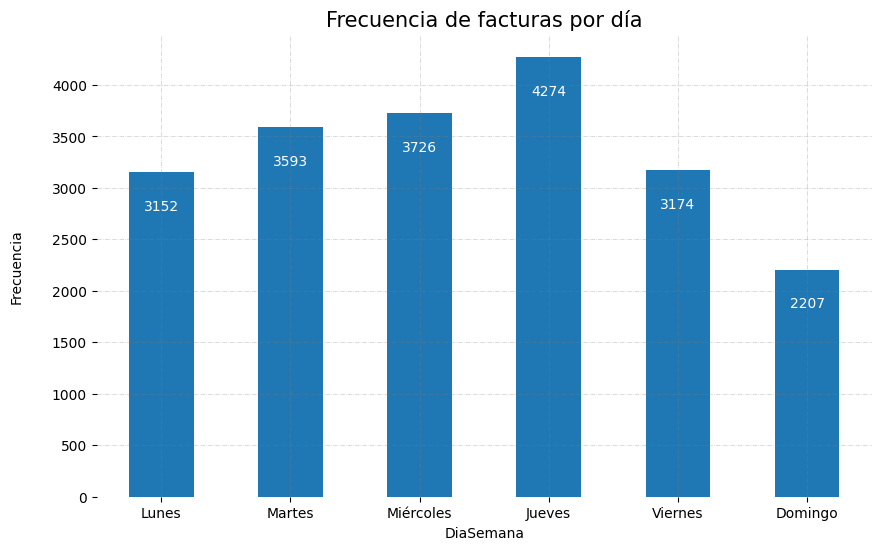

In [229]:
# Graficar la cantidad de ordenes (Invoice) por cada día de la semana. 

InvoiceDate = df_retail.groupby(['InvoiceNo'])['DiaSemana'].unique()
F = pd.DataFrame(InvoiceDate.value_counts()).sort_index()["count"]
print(F)
plt.figure(figsize=(10, 6))
ax = F.plot(kind='bar')
ax.set_title("Frecuencia de facturas por día", fontsize=15)
ax.set_ylabel('Frecuencia',labelpad=20)
ax.set_xticklabels(["Lunes","Martes","Miércoles","Jueves", "Viernes", "Domingo"], rotation=0)
ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.4)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
rects = ax.patches
labels = F.tolist()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, height - 400, label,
            ha='center',va='bottom',color="white")
plt.show()

In [230]:
print("La información anterior corresponde al periodo desde:")
min_fecha = df_retail['InvoiceDate'].min().strftime("%d %B, %Y")
max_fecha = df_retail['InvoiceDate'].max().strftime("%d %B, %Y")
print(str(min_fecha) + " -- "  + str(max_fecha))

La información anterior corresponde al periodo desde:
01 December, 2010 -- 09 December, 2011



**La mayor cantidad de órdenes se producen los Jueves, mientras que los Sábados no ocurre ninguna.**



---



#### 2. Gasto Promedio de Paises

In [231]:
### ¿Cuales son los 5 países que más compran en promedio? grafico y tabla

gastos = df_retail.groupby(['Country'], as_index=False)["Gasto_producto"].mean()
G = gastos.sort_values("Gasto_producto")[-5:]
G # TABLA TOP5 PAISES QUE MÁS GASTAN EN PROMEDIO POR TIPO PRODUCTO


,Country,Gasto_producto
32,Sweden,85.096075
30,Singapore,95.852658
20,Japan,116.561900
0,Australia,116.895620
24,Netherlands,120.798282


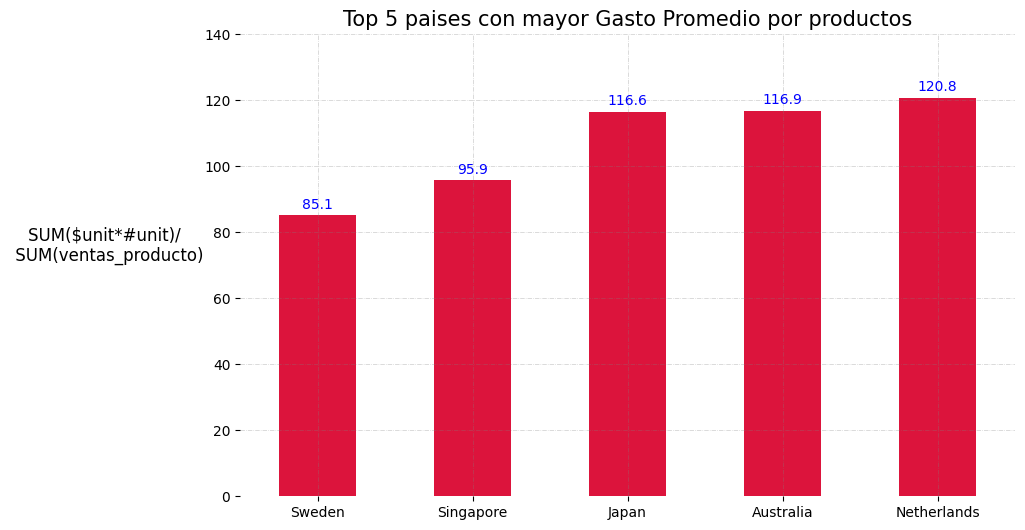

In [232]:
# GRÁFICO PAISES QUE MÁS GASTAN EN PROMEDIO POR PRODUCTO
plt.figure(figsize=(10, 6))
ax = G["Gasto_producto"].plot(kind='bar', color='crimson')
ax.set_title("Top 5 paises con mayor Gasto Promedio por productos", fontsize=15)
ax.set_ylabel('SUM($unit*#unit)/ \n SUM(ventas_producto)',fontsize=12, labelpad=70, rotation=0)
ax.set_ylim(0,140)
ax.set_xticklabels(G["Country"].tolist(), rotation=0)
ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.4)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
rects = ax.patches
labels = G["Gasto_producto"].tolist()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, height+1, format(label, '.1f'),
            ha='center',va='bottom',color="b")
plt.show()

In [233]:
gastos_ = df_retail.groupby('InvoiceNo', as_index=False).agg(
    Gasto_producto=('Gasto_producto', sum), #suma el gasto total de todos los productos de cada factura
    Country=('Country',max) #simplemente agrega la columna de paises al groupby
    )
gastos_2 = gastos_.groupby(['Country'], as_index=False)["Gasto_producto"].mean()
G2 = gastos_2.sort_values("Gasto_producto")[-5:]
G2 # TOP 5 PAISES QUE MÁS GASTAN EN PROMEDIO POR FACTURA

,Country,Gasto_producto
21,Lebanon,1693.880000
20,Japan,1969.282632
0,Australia,2430.198421
24,Netherlands,3004.698316
30,Singapore,3039.898571


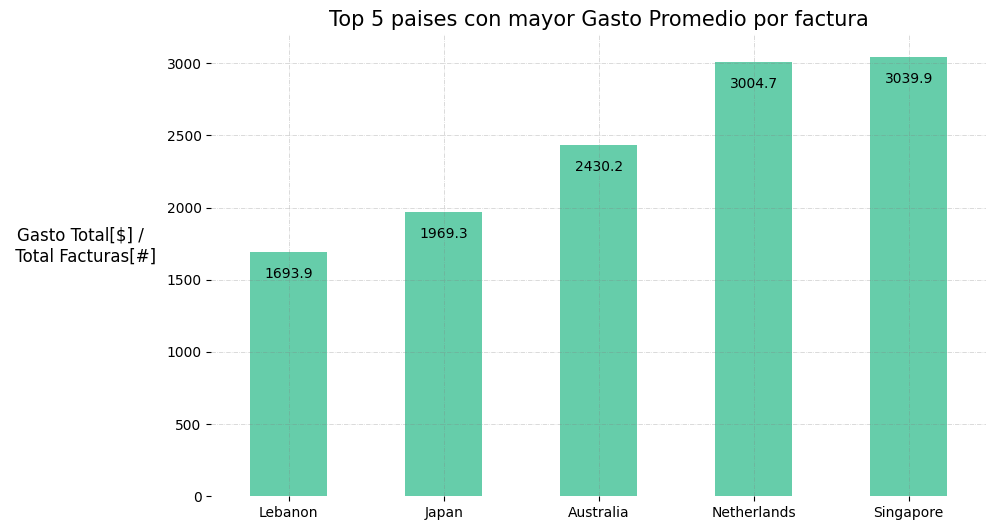

In [234]:
# GRÁFICO PAISES QUE MÁS GASTAN EN PROMEDIO POR PRODUCTO
plt.figure(figsize=(10, 6))
ax = G2["Gasto_producto"].plot(kind='bar', color='mediumaquamarine')
ax.set_title("Top 5 paises con mayor Gasto Promedio por factura", fontsize=15)
ax.set_ylabel('Gasto Total[$] / \n Total Facturas[#]',fontsize=12,labelpad=60, rotation=0)
ax.set_ylim(0,3200)
ax.set_xticklabels(G2["Country"].tolist(), rotation=0)
ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.4)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
rects = ax.patches
labels = G2["Gasto_producto"].tolist()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, height-200, format(label, '.1f'),
            ha='center',va='bottom',color="black")
plt.show()

#### 3. Regalos

In [235]:
# La lista de regalos equivale a los registros con precio 0.0
regalo=df_retail[df_retail['UnitPrice']==0] 
sumatoria = '''
La cantidad de regalos por tipo de producto (lote) desde el
"%s" hasta el "%s" es de: %i
''' %(min_fecha, max_fecha, len(regalo.Description.unique()))
print(sumatoria)


La cantidad de regalos por tipo de producto (lote) desde el
"01 December, 2010" hasta el "09 December, 2011" es de: 240



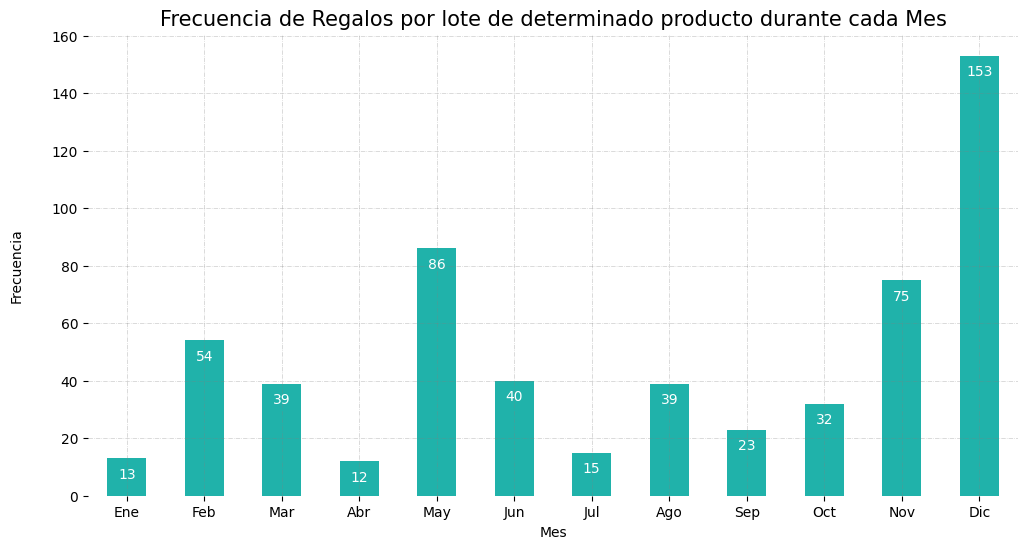

In [236]:
# Graficar la cantidad de regalos (por tipo producto) según mes 

F = regalo.groupby('Mes')["Mes"].count()
plt.figure(figsize=(12, 6))
ax = F.plot(kind='bar',color="lightseagreen")
ax.set_title("Frecuencia de Regalos por lote de determinado producto durante cada Mes", fontsize=15)
ax.set_ylabel('Frecuencia',labelpad=20)
ax.set_xticklabels(["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"], rotation=0)
ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.4)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
rects = ax.patches
labels = F.tolist()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, height - 8, label,
            ha='center',va='bottom',color="white")
plt.show()

##### Sumatoria por Unidad

In [237]:
print("La cantidad de regalos por unidad \ndesde el "+ min_fecha + " al "  + max_fecha + " es de: %i" %(regalo["Quantity"].sum()) )

La cantidad de regalos por unidad 
desde el 01 December, 2010 al 09 December, 2011 es de: 31944


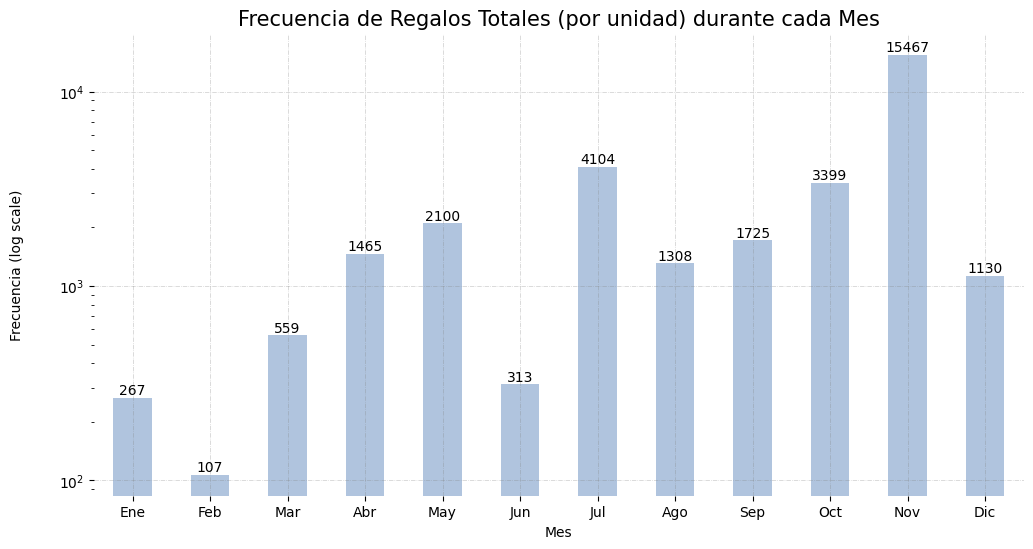

In [238]:
# Graficar la cantidad de regalos (por unidad) según mes 

F = regalo.groupby('Mes')["Quantity"].sum()
plt.figure(figsize=(12, 6))
ax = F.plot(kind='bar',color="lightsteelblue")
ax.set_title("Frecuencia de Regalos Totales (por unidad) durante cada Mes", fontsize=15)
ax.set_ylabel('Frecuencia (log scale)',labelpad=25)
ax.set_yscale('log')
ax.set_xticklabels(["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"], rotation=0)
ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.4)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
rects = ax.patches
labels = F.tolist()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, height, label,
            ha='center',va='bottom',color="black")
plt.show()

##### Sumatoria por facturas

In [239]:
IM= regalo.groupby(['InvoiceNo'])['Mes'].unique()
F = pd.DataFrame(IM.value_counts()).sort_index()["count"]

In [240]:
print("La cantidad de regalos por Factura \ndesde el "+ min_fecha + " al "  + max_fecha + " es de %i" %(F.sum()))
#Por lo tanto existen aproximadamente 19 lotes de productos que comparten factura con otro lote de determinado producto

La cantidad de regalos por Factura 
desde el 01 December, 2010 al 09 December, 2011 es de 221


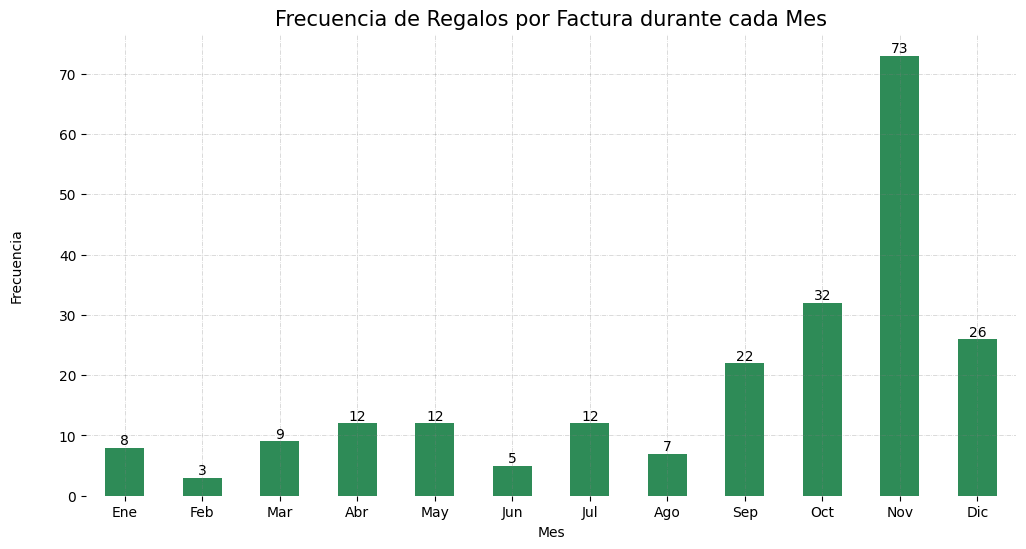

In [241]:
# Graficar la cantidad de regalos (por factura) según mes 

plt.figure(figsize=(12, 6))
ax = F.plot(kind='bar',color="seagreen")
ax.set_title("Frecuencia de Regalos por Factura durante cada Mes", fontsize=15)
ax.set_ylabel('Frecuencia',labelpad=25)
#ax.set_yscale('log')
ax.set_xticklabels(["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"], rotation=0)
ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.4)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
rects = ax.patches
labels = F.tolist()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, height, label,
            ha='center',va='bottom',color="black")
plt.show()